# Step 2, Atakan Devrent

As a team, we have decided to select *Modeling non-stationarity and finding an equilibrium* as our model of choice. For this step, I am going to use **Bitcoin** daily price data in USD for the last 2 years as my dataset. First, we are going to test if the **BTC/USD** dataset is stationary, and if not we are going to take the necessary statistical measures to model our non-stationary time series.

In [61]:
# Import libraries
import numpy as np
import pandas as pd
import yfinance as yf
import datetime
from arch import arch_model
from statsmodels.tsa.stattools import adfuller
from matplotlib import pyplot as plt

[*********************100%%**********************]  1 of 1 completed
                     BTC
Date                    
2022-01-03  46458.117188
2022-01-04  45897.574219
2022-01-05  43569.003906
2022-01-06  43160.929688
2022-01-07  41557.902344


<Axes: title={'center': 'BTC-USD'}, xlabel='Date'>

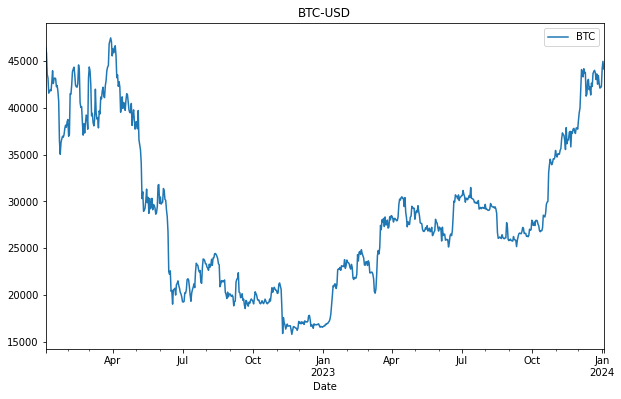

In [62]:
# Initialize dates
end = datetime.datetime.now()
timedelta = datetime.timedelta(2 * 365)
start = end - timedelta

# Download dataset
df = pd.DataFrame(yf.download("BTC-USD", start, end)["Adj Close"])
df.columns = ["BTC"]

# Show first few rows of dataframe
print(df.head())

# Plot the dataframe
df.plot(figsize=(10, 6), title="BTC-USD")

The time series plot show non-constant mean and changing variance. Then we proceed to formally test for **stationarity** with Augmented Dickey-Fuller test. ADF is a statistical test in which the null and alternative hypotheses are as follows:

$H_0:$ There exists a unit root in the time series sample and therefore it is <u> not</u> stationary.

$H_1:$ A unit root <u> does not</u> exist in the time series sample and it is **stationary**.

In [63]:
# Conduct and print the results of Augmented Dickey-Fuller test
adf_test = adfuller(df, maxlag=12)
adf_test
print("ADF Statistic =", adf_test[0])
print("p-value =", adf_test[1])
print("Critical values:", adf_test[4])

ADF Statistic = -1.264316684951886
p-value = 0.6453353276157273
Critical values: {'1%': -3.439464954327953, '5%': -2.8655625802683473, '10%': -2.5689120852623457}


According to the ADF test results, our time series is <u>not</u> stationary because $p > 0.05$.

Then, we can take the **first difference** of our time series and check for stationarity again. However because we know our dataset is the value of financial asset prices, we can use **log returns** as the first difference instead and then check for stationarity:

                     BTC  BTC_logr
Date                              
2022-01-04  45897.574219 -0.012139
2022-01-05  43569.003906 -0.052066
2022-01-06  43160.929688 -0.009410
2022-01-07  41557.902344 -0.037848
2022-01-08  41733.941406  0.004227


<Axes: title={'center': 'BTC log returns'}, xlabel='Date'>

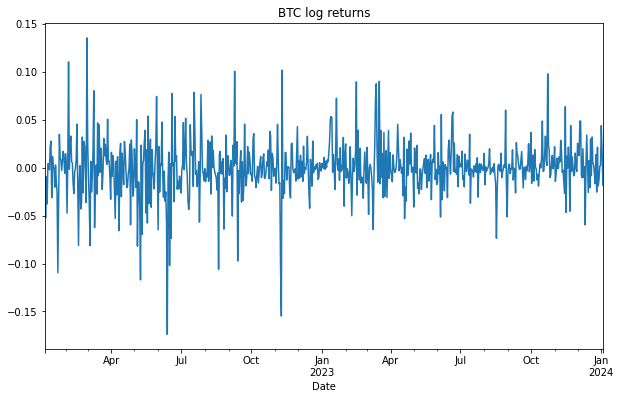

In [64]:
# Store the first difference into our dataframe
df["BTC_logr"] = np.log((df / df.shift(1)))
df = df.dropna()  # drop NaN values

# Show the first few rows of dataframe
print(df.head())

# Plot first difference data
df["BTC_logr"].plot(figsize=(10, 6), title="BTC log returns")

Although we seem to have a constant mean, we also seem to have **volatility clustering** and therefore, non-constant variance for this time series; possibly making it non-stationary. Let's formally check for stationarity of the first difference time series with an ADF test:

In [65]:
adf_test_delta1 = adfuller(df["BTC_logr"], maxlag=12)
print("ADF statistic =", adf_test_delta1[0])
print("p-value =", adf_test_delta1[1])
print("Critical values:", adf_test[4])

ADF statistic = -26.80969714710864
p-value = 0.0
Critical values: {'1%': -3.439464954327953, '5%': -2.8655625802683473, '10%': -2.5689120852623457}


According to the ADF test, log returns of **BTC-USD** time series is **stationary**. Then, this time series is a good candidate for a **GARCH** (Generalized Autoregressive Conditional Heteroscedasticity) model because it is <u>unconditionally homoscedastic</u> but has several volatility clusters and therefore can be considered <u>conditionally heteroscedastic</u> .

The reason for choosing **GARCH** over **ARCH** (Autoregressive Conditional Heteroscedasticity) is because the GARCH model is more **parsimonious** than the ARCH model. This is because in the GARCH model we also include the lagged value of the $\sigma_t^2$ term, which is the variance of the residuals. This weighting allows us to include the impact of past variance as an exponentially decaying factor with a coefficient in our calculation; in contrast to ARCH assumption that the impact of past $\sigma_{t-h}^2$ values decay linearly over time.

Then, let's define the **GARCH** model and describe its use in modeling stationary time series with volatility clusters:

## Definition and Description

A **GARCH(p, q)** model is just an extension of an **ARCH(p)** model where we include the past values of $\sigma_t$ on the right hand side. Let {$X_t$} be a <u>stationary</u> asset rate of return (for example log return) time series model such that:

$X_t = \mu + \varepsilon_t$

where

> $X_t:$ Asset rate of return at time $t$

> $\mu:$ <u>Unconditional</u> expected value (mean) of $X_t$, which is a <u>constant</u> 

> $\varepsilon_t:$ innovation term (residual term)

and

$Var(\varepsilon_t) = \sigma_t^2$ 

where $\sigma_t^2$ is a function of $t$ and is <u>not</u> a constant.

For financial asset time series, we generally assume $\mu=0$. If we proceed with this assumption, $X_t = \varepsilon_t$.

Then we define $Var(\varepsilon_t) = \sigma_t^2$ term with the following equation:

$\sigma_t^2 = \omega + \alpha_1 \varepsilon_{t-1}^2 + \cdots + \alpha_p \varepsilon_{t-p}^2 + \beta_1 \sigma_{t-1}^2 + \cdots + \beta_q \sigma_{t-q}^2$

where

> $\varepsilon_t:$ innovation term (residual term) for time series

> $\sigma_t^2:$ Variance of $\varepsilon_t$

> $\omega:$ A constant term which represents the long-run average variance of $\varepsilon_t$

> $\alpha_i:$ Coefficients of $\varepsilon_{t-i}^2$ values, which represent the reaction of current volatility to past **shocks** (ARCH term). Higher values mean more persistence in volatility due to past shocks.

> $\beta_i:$ Coefficients of $\sigma_{t-i}^2$ values, which represent the persistence of past **volatility** (GARCH term). If beta is high, it indicates that volatility clustering is more persistent.

## Demonstration and Diagrams

First we download and conduct an exploratory data analysis on our raw data.

[*********************100%%**********************]  1 of 1 completed
                     BTC
Date                    
2022-01-03  46458.117188
2022-01-04  45897.574219
2022-01-05  43569.003906
2022-01-06  43160.929688
2022-01-07  41557.902344


<Axes: title={'center': 'BTC-USD'}, xlabel='Date'>

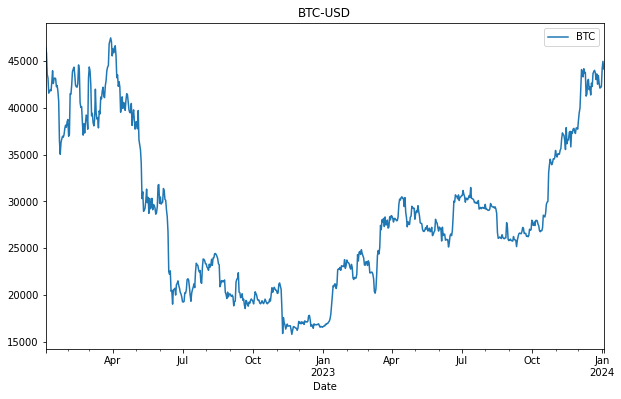

In [66]:
# Import libraries
import numpy as np
import pandas as pd
import yfinance as yf
import datetime
from arch import arch_model
from statsmodels.tsa.stattools import adfuller
from matplotlib import pyplot as plt

# Initialize dates
end = datetime.datetime.now()
timedelta = datetime.timedelta(2 * 365)
start = end - timedelta

# Download dataset
df = pd.DataFrame(yf.download("BTC-USD", start, end)["Adj Close"])
df.columns = ["BTC"]

# Show first few rows of dataframe
print(df.head())

# Plot the dataframe
df.plot(figsize=(10, 6), title="BTC-USD")

Then, as explained in **Step 2** of our paper, we transform the **BTC-USD** price data into log returns to get a **stationary** time series:

                     BTC  BTC_logr
Date                              
2022-01-04  45897.574219 -0.012139
2022-01-05  43569.003906 -0.052066
2022-01-06  43160.929688 -0.009410
2022-01-07  41557.902344 -0.037848
2022-01-08  41733.941406  0.004227


<Axes: title={'center': 'BTC log returns'}, xlabel='Date'>

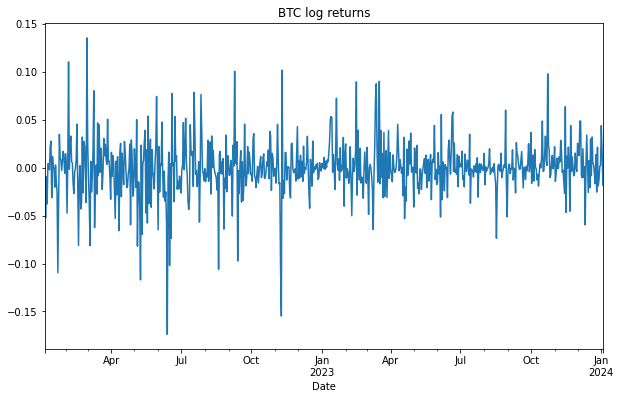

In [67]:
# Store the first difference into our dataframe
df["BTC_logr"] = np.log((df / df.shift(1)))
df = df.dropna()  # drop NaN values

# Show the first few rows of dataframe
print(df.head())

# Plot first difference data
df["BTC_logr"].plot(figsize=(10, 6), title="BTC log returns")

As can be seen in the plot, we are going to address the volatility clusters by fitting a **GARCH(1, 1)** model. We will use the following assumptions in our first model:

* $\mu = 0$

* Innovation terms $\varepsilon_i$ are unconditionally **normally distributed**.

* No **asymmetric** innovation terms are included, such as those in EGARCH

In [68]:
# Fit the GARCH(1, 1) model
endog = df["BTC_logr"]
btc_garch11 = arch_model(endog, mean="Zero", dist="normal", rescale=False).fit()
btc_garch11.summary()

Iteration:      1,   Func. Count:      5,   Neg. LLF: -1018.2566532437759
Iteration:      2,   Func. Count:     13,   Neg. LLF: -1514.5566663159648
Iteration:      3,   Func. Count:     18,   Neg. LLF: -1579.244678112499
Iteration:      4,   Func. Count:     24,   Neg. LLF: -1579.346569545135
Iteration:      5,   Func. Count:     29,   Neg. LLF: -1589.5206189512496
Iteration:      6,   Func. Count:     33,   Neg. LLF: -1589.5296832976042
Iteration:      7,   Func. Count:     37,   Neg. LLF: -1589.529764447872
Iteration:      8,   Func. Count:     40,   Neg. LLF: -1589.5297644480024
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1589.529764447872
            Iterations: 8
            Function evaluations: 40
            Gradient evaluations: 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:               BTC_logr   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:                1589.53
Distribution:                  Normal   AIC:                          -3173.06
Method:            Maximum Likelihood   BIC:                          -3159.28
                                        No. Observations:                  730
Date:                Wed, Jan 03 2024   Df Residuals:                      730
Time:                        14:57:21   Df Model:                            0
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      2.9494e-04  1.389e-04      2.123  3.374e-02 [2.267e-05,5.672e-04]
alpha[1]       0.3411      0.235      1.452      0.146     [ -0.119,  0.801]
beta[1]        0.3614      0.272      1.327      0.184     [ -0.172,  0.895]
============================================================================

Covariance estimator: robust
"""

According to our results after the GARCH(1, 1) fit, we have the following equation for describing our estimate of innovation terms, $\hat{\varepsilon_t}$ :

$\hat{\sigma_t^2} = 2.9495 \cdot 10^{-4} + 0.3406 \varepsilon_{t-1}^2 + 0.3613 \sigma_{t-1}^2$

where

> $\hat{\omega} = 2.9495 \cdot 10^{-4}$

> $\hat{\alpha_1} = 0.3406$

> $\hat{\beta_1} = 0.3613$

However, although $\omega$ term is statistically significant according to the results, $\hat{\alpha_1}$ and $\hat{\beta_1}$ coefficient estimates are **not** significant at the $5 \%$ level. This means we might need to re-calibrate our model to get statistically significant coefficient estimates.

Before reviewing our assumptions and re-calibrating our model, let's show an exploratory plot for our model:

In [69]:
# Assign coefficients
omega = btc_garch11.params[0]
alpha1 = btc_garch11.params[1]
beta1 = btc_garch11.params[2]

# Initialize sigma^2 and epsilon arrays
sigma2_arr = [omega]  # first sigma^2 value is equal to omega
epsilon_arr = [df.iloc[0, 1]]  # first epsilon value is a normal rv with first sigma2 value as variance

# Fill the arrays
for i in range(1, len(df["BTC_logr"])):
    sigma2_arr.append(omega + alpha1*(df.iloc[i-1, 1]**2) + beta1*sigma2_arr[i-1])  # uses lagged BTC_logr values as lagged epsilon values
    epsilon_arr.append(np.random.normal(0, sigma2_arr[i]))
    
# Convert to numpy arrays and store them in our dataframe
df["sigma2"] = np.array(sigma2_arr)
df["epsilon"] = np.array(epsilon_arr)

# Calculate conditional standard deviation (sqrt of conditional variance)
df['conditional_std'] = np.sqrt(df['sigma2'])

# Show the first few rows of dataframe
df.head()

/tmp/ipykernel_2031/3978116204.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["sigma2"] = np.array(sigma2_arr)
/tmp/ipykernel_2031/3978116204.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["epsilon"] = np.array(epsilon_arr)
/tmp/ipykernel_2031/3978116204.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

,BTC,BTC_logr,sigma2,epsilon,conditional_std
Date,,,,,
2022-01-04,45897.574219,-0.012139,0.000295,-0.012139,0.017174
2022-01-05,43569.003906,-0.052066,0.000452,-0.000340,0.021255
2022-01-06,43160.929688,-0.009410,0.001383,0.001612,0.037186
2022-01-07,41557.902344,-0.037848,0.000825,-0.000256,0.028719
2022-01-08,41733.941406,0.004227,0.001082,0.001681,0.032887


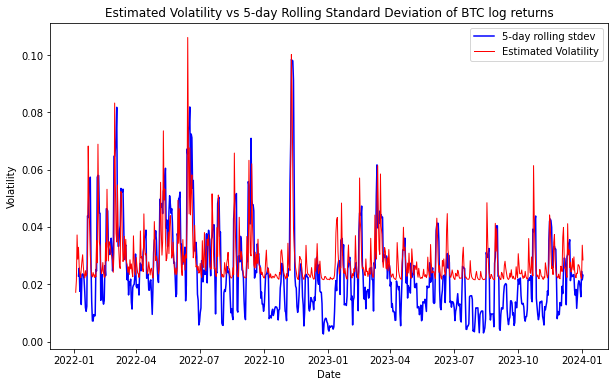

In [70]:
# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(df.index, df['BTC_logr'].rolling(5).std(), label='5-day rolling stdev', color='blue')
ax.plot(df.index, df['conditional_std'], label='Estimated Volatility', color='red', linewidth=1)
ax.set(title="Estimated Volatility vs 5-day Rolling Standard Deviation of BTC log returns", ylabel="Volatility", xlabel="Date")
ax.legend()
plt.show()

As can be seen on the plot, although our volatility estimates have a higher minimum baseline, they tend to capture volatility spikes and clusters reasonably well. In the next section we are going to look at **diagnostic plots** and try to re-calibrate our model to generate a better volatility estimate.

## Diagnosis

> To be written by Surprise and Tan

## Damage

> To be written by Surprise and Tan

## Directions

> To be written by Surprise and Tan

## Deployment

> To be written by Surprise and Tan

*References:*

* https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test

* Lamzihri, Othmane. (2023). Re: Why the GARCH model is more parsimonious as compared to ARCH ?. Retrieved from: https://www.researchgate.net/post/Why_the_GARCH_model_is_more_parsimonious_as_compared_to_ARCH/63b5c0d541500f87e109b43f/citation/download. 